# 1. Exploratory Data Analysis


## 1.1 Basic Information

Beautiful butterflies! 

![Butterflys ](butterfly_collage_3x3.jpg)

**Problem Statement:**

Develop a model that classifies images of butterflies into 75 different categories based on their features. The dataset includes over 9,000 labeled images, divided into training and validation sets. Each image belongs to a single butterfly category.

The labels for the training images are provided in the Training_set.csv file. The Testing_set.csv contains the names of images in the test folder for which you need to predict the corresponding butterfly category

**Dataset:**
Dataset is taken from kaggle - <a href='https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification'>link</a>

**Solution Tech Stack** 
Tensorflow/keras, Scikit-Learn

''' pip install numpy pandas matplotlib seaborn scikit-learn tensorflow kaggle kagglehub ipykernel jupyterlab_widgets
'''

**Note:** The dataset is huge so it will take time to train. =) Also, you must be setup for kaggle to access programmatically. See here for more details.

## 1.0 Imports

In [33]:
# === Suppress Warnings ===
import warnings
warnings.filterwarnings("ignore")

# === Core Python & Data Handling ===
import os
import numpy as np
import pandas as pd

# === Kaggle API ===
import kaggle

# === Data Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === TensorFlow / Keras ===
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
    GlobalAveragePooling2D,
    BatchNormalization
)
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img
)

# === Machine Learning Utilities ===
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


## 1.1 Fetch & Load

In [3]:
# Directory to save the dataset
output_dir = "./kaggle_dataset"
filename = "Training_set.csv"
file_path = os.path.join(output_dir, filename)

if not os.path.exists(file_path):
    # Dataset identifier from the URL
    dataset = "phucthaiv02/butterfly-image-classification"

    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Download the dataset
    kaggle.api.dataset_download_files(dataset, path=output_dir, unzip=True)

    print(f"Dataset downloaded and extracted to {output_dir}")
else:
    print(f"Dataset already exists at {file_path}")

# Load the dataset from a CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the first five rows of the DataFrame to get an initial overview of the data
df.head(10)


Dataset already exists at ./kaggle_dataset\Training_set.csv


,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART
5,Image_6.jpg,CAIRNS BIRDWING
6,Image_7.jpg,GREEN CELLED CATTLEHEART
7,Image_8.jpg,EASTERN DAPPLE WHITE
8,Image_9.jpg,BROWN SIPROETA
9,Image_10.jpg,RED POSTMAN


## 1.2 Examine Target Variable

### 1.2.1 Analyze class distribution

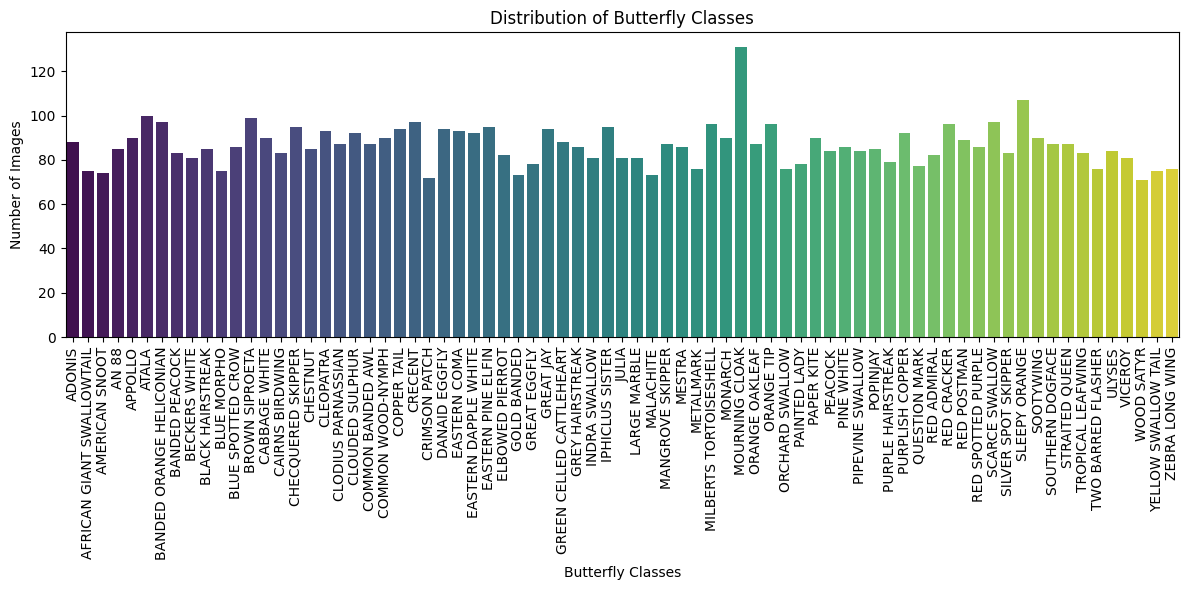

In [3]:
# Count the number of occurrences for each class label and sort them by index (class order)
class_counts = df['label'].value_counts().sort_index()

# Set the figure size for the plot
plt.figure(figsize=(12, 6))

# Create a bar plot to visualize the distribution of butterfly classes
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

# Add a title to the plot
plt.title('Distribution of Butterfly Classes')

# Label the x-axis with 'Butterfly Classes'
plt.xlabel('Butterfly Classes')

# Label the y-axis with 'Number of Images'
plt.ylabel('Number of Images')

# Rotate the x-axis labels for better readability (useful if the class names are long or numerous)
plt.xticks(rotation=90)

# Adjust the layout to ensure everything fits within the figure
plt.tight_layout()

# Display the plot
plt.show()

## Insight & Analysis:

**Class Imbalance**: While many classes have around 80–100 images, there is a noticeable variance. Some classes (like the one near the middle with the tallest bar) have well over 130 images, while others have less than 75.

**Long Tail Distribution**: The chart shows a long-tail pattern, where a few classes have many images and many classes have fewer.

**Balanced Enough for Some Models**: Although not perfectly balanced, the distribution is not extremely skewed. Most classes cluster reasonably close in count, which can still be workable for many machine learning models without heavy resampling.

## 1.2.2 Data Visualization Sampling

./kaggle_dataset/train/Image_6495.jpg
./kaggle_dataset/train/Image_6494.jpg
./kaggle_dataset/train/Image_6493.jpg
./kaggle_dataset/train/Image_6492.jpg
./kaggle_dataset/train/Image_6491.jpg
./kaggle_dataset/train/Image_6490.jpg


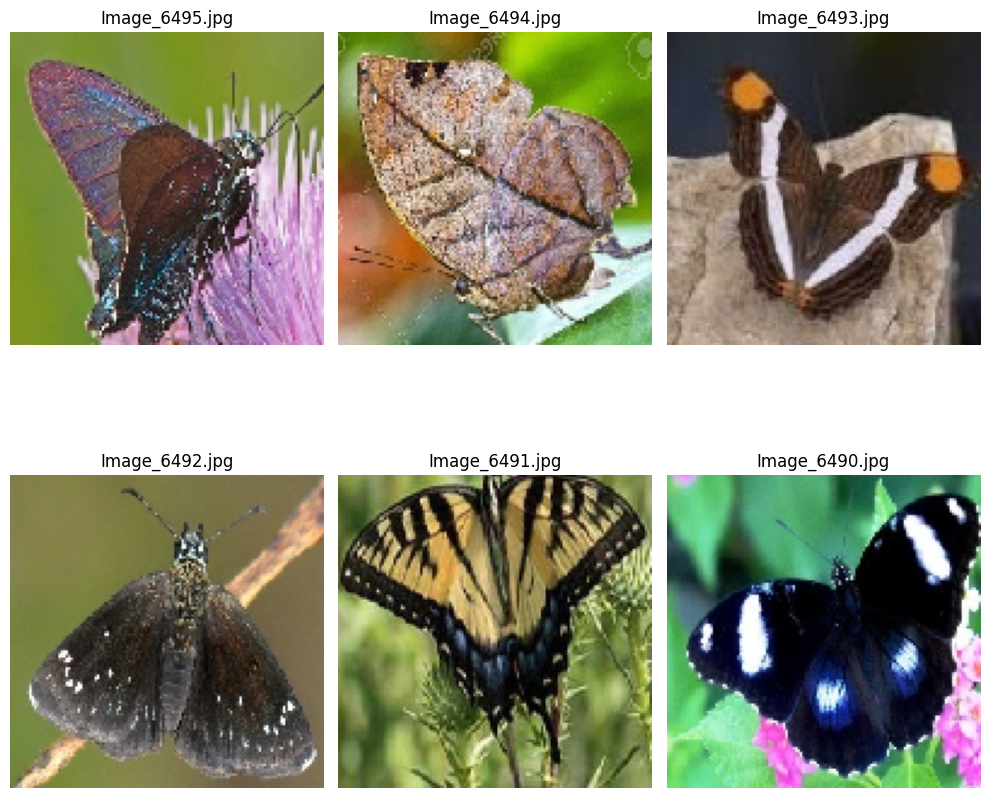

In [4]:
# Define the directory and limit the filenames to 6 images

# Directory to save the dataset
image_dir = "./kaggle_dataset/train/"
filenames = [f"Image_{i}.jpg" for i in range(6495, 6489, -1)]  # Generate only 6 filenames

# Set up the plot with a fixed 2x3 grid (6 images)
fig, axes = plt.subplots(2, 3, figsize=(10, 10))  # 2 rows, 3 columns
axes = axes.ravel()  # Flatten axes array for easier indexing

for i, filename in enumerate(filenames):
    img_path = os.path.join(image_dir, filename)  # Full path to the image
    print(img_path)  # Print the file path

    img = load_img(img_path, target_size=(130, 130))  # Load and resize the image
    img_array = img_to_array(img) / 255.0  # Normalize pixel values

    ax = axes[i]  # Get subplot position
    ax.imshow(img_array)  # Display the image
    ax.set_title(f"{filename}")  # Set the title as the filename
    ax.axis('off')  # Remove axis for cleaner visuals

# Hide any unused subplots (not needed here as we are displaying exactly 6 images)
for j in range(len(filenames), len(axes)):
    axes[j].axis('off')

plt.tight_layout()  # Ensure proper spacing
plt.show()  # Display the grid

## Insight:
* RGB is absolutely necessary for reliable classification of these images. 
* Grayscale would severely hinder accuracy, especially for mimetic (mimicing other specias) or cryptic (camoflauging) species.

# 2. Data Preprocessing

## 2.1 Data Splitting

The provided dataset is already split into train and test, but we will further refine the train data to have our own train/test/validate split. Then cycling around on the unseen data to see how the models do.

In [4]:
# Split into train (70%) and temp (30%) [temp will be further split into val and test]
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Split the temp dataset into validation (20%) and test (10%)
val_df, test_df = train_test_split(temp_df, test_size=1/3, random_state=42)  # 1/3 of 30% = 10%

## 2.2 Image dataset creation

The train_datagen object is an instance of the ImageDataGenerator class from TensorFlow/Keras, which is used for data augmentation in image datasets. Data augmentation involves applying random transformations to training images to artificially expand the dataset and improve the model's generalization.

Image augmentation help the model generalize better by simulating variations in real-world data, thus reducing overfitting. Common augmentation techniques include:

- **Rotation:** Randomly rotating images to account for different orientations.
- **Flipping:** Horizontally or vertically flipping images.
- **Zooming:** Randomly zooming in or out on parts of the image.
- **Shifting:** Randomly shifting the image along the width or height.
- **Brightness Adjustment:** Varying the brightness to simulate lighting changes.

In the provided code, ImageDataGenerator applies such transformations during training. It ensures that the model sees diverse variations of the images at every epoch, improving robustness and performance.



In [52]:
image_dir = './kaggle_dataset/train/'

# Data augmentation for training images to improve model generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values to [0, 1]
    rotation_range=40,            # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,        # Randomly shift images horizontally by 20% of width
    height_shift_range=0.2,       # Randomly shift images vertically by 20% of height
    shear_range=0.2,              # Apply random shearing transformations
    zoom_range=0.2,               # Randomly zoom in or out by 20%
    horizontal_flip=True,         # Randomly flip images horizontally
    fill_mode='nearest'           # Fill missing pixels with the nearest pixel values
)

# Generate batches of augmented training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,           # Training dataset
    directory=image_dir,          # Path to images
    x_col='filename',             # Column with image file names
    y_col='label',                # Column with corresponding labels
    target_size=(150, 150),       # Resize images to 150x150
    batch_size=32,                # Number of images per batch
    class_mode='categorical'      # Labels are categorical
)

Found 4549 validated image filenames belonging to 75 classes.


In [53]:
# Data generator for test images (no augmentation, only normalization)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,            # Test dataset
    directory=image_dir,          # Path to images
    x_col='filename',             # Column with image file names
    y_col='label',                # Column with corresponding labels
    target_size=(150, 150),       # Resize images to 150x150
    batch_size=32,                # Number of images per batch
    class_mode='categorical'      # Labels are categorical
)

Found 650 validated image filenames belonging to 75 classes.


In [54]:
# Data generator for validation images (no augmentation, only normalization)
val_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of validation data
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,             # Validation dataset
    directory=image_dir,          # Path to images
    x_col='filename',             # Column with image file names
    y_col='label',                # Column with corresponding labels
    target_size=(150, 150),       # Resize images to 150x150
    batch_size=32,                # Number of images per batch
    class_mode='categorical'      # Labels are categorical
)

Found 1300 validated image filenames belonging to 75 classes.


### 🔄 **Training Data Augmentation**

* Creates an `ImageDataGenerator` object (`train_datagen`) with several augmentation techniques to artificially expand the training dataset and improve model generalization:

  * **rescale=1./255**: Normalizes image pixel values to the range \[0, 1].
  * **rotation\_range=40**: Randomly rotates images by up to 40 degrees.
  * **width\_shift\_range=0.2**: Shifts images horizontally by up to 20%.
  * **height\_shift\_range=0.2**: Shifts images vertically by up to 20%.
  * **shear\_range=0.2**: Applies shear transformation (tilting).
  * **zoom\_range=0.2**: Zooms in/out on the image by up to 20%.
  * **horizontal\_flip=True**: Randomly flips images horizontally.
  * **fill\_mode='nearest'**: Fills in new pixels created from transformations using nearest neighbor interpolation.

### 🏋️ **Training Data Generator**

* Uses `flow_from_dataframe()` to:

  * Load image data from `train_df` using filenames and labels.
  * Reads images from `image_dir`.
  * Resizes them to 150x150 pixels.
  * Creates batches of 32 images.
  * Uses `categorical` class mode (for one-hot encoded labels).
  * Applies the above augmentation to each batch during training.

### 🧪 **Test Data Preparation**

* Creates a simpler `ImageDataGenerator` (`test_datagen`) that only rescales the images (no augmentation).
* Generates batches of test data with `flow_from_dataframe()` using:

  * `test_df` for filenames and labels.
  * Resized to 150x150.
  * Batches of 32.
  * `categorical` class mode.

### 📊 **Validation Data Preparation**

* Similar to test data: uses `ImageDataGenerator` (`val_datagen`) for rescaling only.
* Loads validation data from `val_df` with:

  * Resizing to 150x150.
  * Batching (32).
  * No augmentation; just normalization.
  * Useful for evaluating model performance during training without altered inputs.



# 3. Model Training and Evaluation

This phase involves using the prepared datasets (training, validation, and test) to train the model on the training set, monitor its performance on the validation set, and assess its final accuracy on the test set. The goal is to optimize the model's ability to generalize to unseen data while minimizing overfitting. Metrics such as accuracy, precision, recall, and loss are used to evaluate the model's performance.

## 3.1 Fully Connected Neural Network (FNN)

An FNN is a type of artificial neural network where each neuron in one layer is connected to every neuron in the next layer. It is composed of an input layer, one or more hidden layers, and an output layer. FNNs are used for various tasks, including classification and regression, by learning patterns from the input data through weighted connections and non-linear activation functions.

<img src="./fnn.png" alt="FNN Diagram" width="600" height="500">


In [9]:
# Define the input image shape
input_shape = (150, 150, 3)

# Create the FNN model
model_FNN = Sequential([
    # Flatten the 3D input image into a 1D vector
    Flatten(input_shape=input_shape),

    # First Dense layer with 1024 neurons, Batch Normalization, and ReLU activation
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),  # Dropout for regularization

    # Second Dense layer with 512 neurons, Batch Normalization, and ReLU activation
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),  # Dropout for regularization

    # Third Dense layer with 256 neurons, Batch Normalization, and ReLU activation
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),  # Dropout for regularization

    # Fourth Dense layer with 128 neurons, Batch Normalization, and ReLU activation
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),  # Dropout for regularization

    # Output layer with 75 neurons (for 75 classes) and softmax activation
    Dense(75, activation='softmax')
])

# Compile the model
model_FNN.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Change to categorical_crossentropy
    metrics=['accuracy']           # Metrics to monitor
)

# Model summary
model_FNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    69,121,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 75)             │         9,675 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,827,403 (266.37 MB)

 Trainable params: 69,823,563 (266.36 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [24]:
from tensorflow.keras.models import load_model
import os

model_path = ".\model_FNN.keras"

if os.path.exists(model_path):
    model_FNN = load_model(model_path)
    print("FNN Model loaded.")
else:
    # Continue training and save history
    history = model_FNN.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=40,
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size
    )

    # Save the entire model to a file
    model_FNN.save(model_path)


FNN Model loaded.


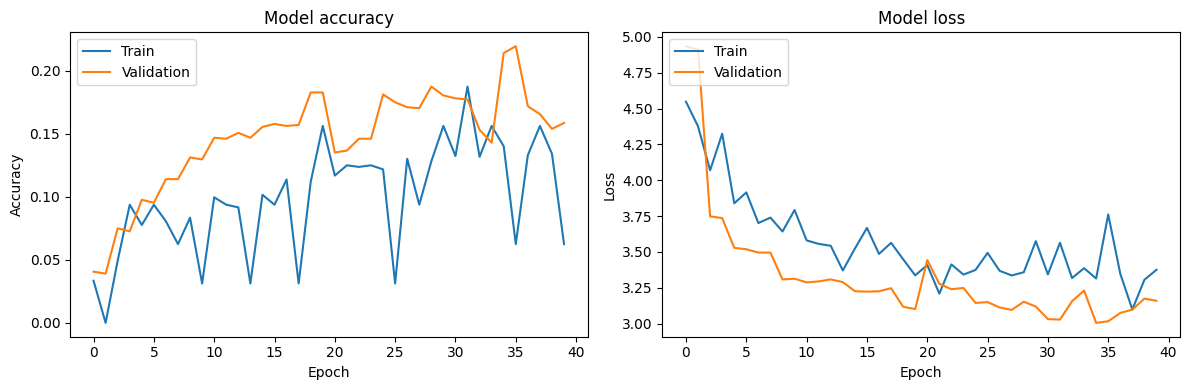

In [16]:
plt.figure(figsize=(12, 4))  # Set the figure size for the plots

# Plot accuracy
plt.subplot(1, 2, 1)  # Create the first subplot (1 row, 2 columns, 1st plot)
plt.plot(history.history['accuracy'])  # Plot training accuracy over epochs
plt.plot(history.history['val_accuracy'])  # Plot validation accuracy over epochs
plt.title('Model accuracy')  # Set the title for the accuracy plot
plt.ylabel('Accuracy')  # Label for the y-axis
plt.xlabel('Epoch')  # Label for the x-axis
plt.legend(['Train', 'Validation'], loc='upper left')  # Add legend

# Plot loss
plt.subplot(1, 2, 2)  # Create the second subplot (1 row, 2 columns, 2nd plot)
plt.plot(history.history['loss'])  # Plot training loss over epochs
plt.plot(history.history['val_loss'])  # Plot validation loss over epochs
plt.title('Model loss')  # Set the title for the loss plot
plt.ylabel('Loss')  # Label for the y-axis
plt.xlabel('Epoch')  # Label for the x-axis
plt.legend(['Train', 'Validation'], loc='upper left')  # Add legend

plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()  # Display the plots

### 3.2.1 Interpretation
---

### 📈 **Left Plot: Model Accuracy**

* **Train Accuracy** is noisy and low, fluctuating around 0.05–0.15.
* **Validation Accuracy** steadily increases up to \~0.2, then levels off.
* **Interpretation**:

  * Model is **learning**, as validation accuracy improves early on.
  * Training accuracy's instability suggests:

    * Small dataset
    * High variance due to augmentation
    * Possibly a model that’s not complex enough or not yet well-tuned

---

### 📉 **Right Plot: Model Loss**

* **Training Loss** decreases with fluctuations but remains high (\~3.0–4.5).
* **Validation Loss** drops quickly and then stabilizes around \~3.0.
* **Interpretation**:

  * **Validation loss improves faster and stays lower** than training loss — this is unusual.
  * It might indicate:

    * **Regularization (dropout, augmentation)** making training harder
    * Or **over-regularization**, causing underfitting
    * Possibly **data leakage** or label mismatch between train/validation

---

### 🧠 Overall:

* Model is **not overfitting**, which is good.
* But it also might not be **fitting well enough** (low accuracy, high loss).
* Considerations:

  * **Increase model capacity** (more layers/neurons)
  * **Train longer** (more epochs)
  * **Tune learning rate / optimizer**
  * Check for **label imbalance or noise**
  * **Review augmentation**: too much may hurt training
  * **Different Approach**: model not right fit, npi.

## 3.2 Convolutional Neural Network (CNNs)

A Convolutional Neural Network (CNN) is a deep learning model specifically designed to process and classify visual data by learning spatial hierarchies of features through convolutional layers. It uses filters to detect patterns such as edges, textures, and shapes, making it highly effective for image recognition and classification tasks.

<img src="./cnn.png" alt="CNN Diagram" width="600" height="500">

In [17]:
model_CNN = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(75, activation='softmax')
])

model_CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model_CNN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 75)             │        38,475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,072,139 (72.75 MB)

 Trainable params: 19,072,139 (72.75 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

from tensorflow.keras.models import load_model
import os

model_path = ".\model_CNN.keras"

if os.path.exists(model_path):
    model_FNN = load_model(model_path)
    print("CNN Model loaded.")
else:
    # Continue training and save history
    history = model_CNN.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=40,
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size
    )

# Save the entire model to a file
model_CNN.save(model_path)

CNN Model loaded.


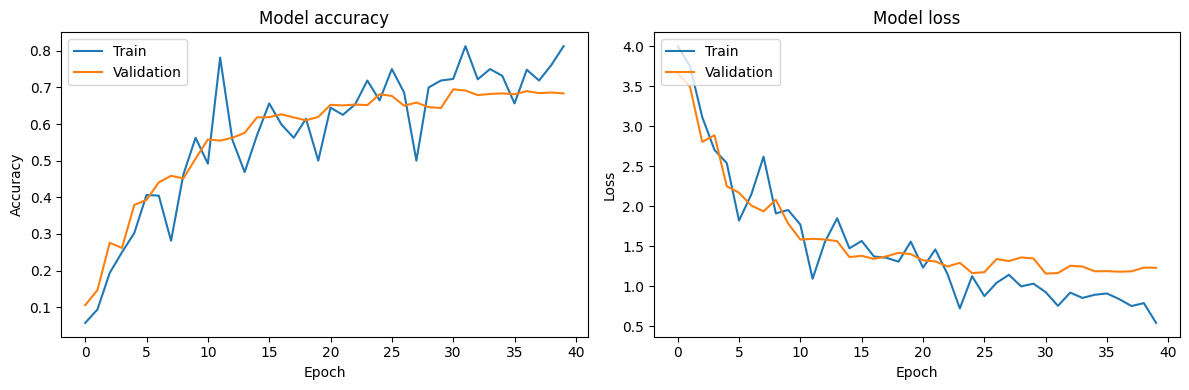

In [ ]:

if history is not None:
    plt.figure(figsize=(12, 4))  # Set the figure size for the plots

    # Plot accuracy
    plt.subplot(1, 2, 1)  # Create the first subplot (1 row, 2 columns, 1st plot)
    plt.plot(history.history['accuracy'])  # Plot training accuracy over epochs
    plt.plot(history.history['val_accuracy'])  # Plot validation accuracy over epochs
    plt.title('Model accuracy')  # Set the title for the accuracy plot
    plt.ylabel('Accuracy')  # Label for the y-axis
    plt.xlabel('Epoch')  # Label for the x-axis
    plt.legend(['Train', 'Validation'], loc='upper left')  # Add legend

    # Plot loss
    plt.subplot(1, 2, 2)  # Create the second subplot (1 row, 2 columns, 2nd plot)
    plt.plot(history.history['loss'])  # Plot training loss over epochs
    plt.plot(history.history['val_loss'])  # Plot validation loss over epochs
    plt.title('Model loss')  # Set the title for the loss plot
    plt.ylabel('Loss')  # Label for the y-axis
    plt.xlabel('Epoch')  # Label for the x-axis
    plt.legend(['Train', 'Validation'], loc='upper left')  # Add legend

    plt.tight_layout()  # Adjust the layout to prevent overlapping
    plt.show()  # Display the plots
else:
    print("No training history available to plot.")

### 3.2.1 Analysis & Summary:

### 📈 **Model Accuracy (Left Plot)**

* **Training Accuracy** increases steadily, reaching \~0.80 by epoch 40.
* **Validation Accuracy** improves early and then **plateaus** around 0.65–0.70.
* **Interpretation**:

  * The model is learning well from the training data.
  * Slight gap between training and validation accuracy suggests **moderate overfitting** starting around epoch 25.

---

### 📉 **Model Loss (Right Plot)**

* **Training Loss** consistently decreases, with a few fluctuations.
* **Validation Loss** drops early and then **flattens**, starting to slightly rise around epoch 30.
* **Interpretation**:

  * The training process is effective.
  * The divergence in loss curves after \~epoch 25 suggests the model is **starting to overfit** (training continues to improve, validation does not).

---

### 🧠 Summary

| Metric      | Observation                          | Suggestion                           |
| ----------- | ------------------------------------ | ------------------------------------ |
| Accuracy    | Training > Validation (\~10–15% gap) | Slight overfitting                   |
| Loss        | Validation loss plateaus then rises  | Use early stopping or regularization |
| General Fit | Model is learning well               | Tweak model to generalize better     |

---

### ✅ Suggestions:

* Use **EarlyStopping** to halt training when validation loss stops improving.
* Consider adding or increasing **Dropout**.
* Optionally reduce model complexity if overfitting increases further.


## Comparitive Analysis FNN & CNN


**CNN better suited** for the image classifications? At least in this example, CNN has at least a 4-5X better accuracy .

| Feature           | FNN                                             | CNN                                              |
| ----------------- | ----------------------------------------------- | ------------------------------------------------ |
| Layer Type        | Dense (fully connected)                         | Convolutional + Pooling + Dense                  |
| Spatial Awareness | ❌ None – treats each pixel independently        | ✅ Learns spatial features like edges, textures   |
| Weight Sharing    | ❌ Each pixel has its own weights                | ✅ Same filter applied across image               |
| Input Shape       | Requires 1D flattened input (e.g., 28x28 → 784) | Accepts 2D image inputs directly (e.g., 28x28x3) |


## 3.3 Transfer Learning

Transfer learning is a deep learning technique where a pre-trained model's learned features are reused to solve a new, related task with limited data. It reduces training time and improves performance, especially in image and language tasks where labeled data is scarce.

<img src="./trnsfer_learning.png" alt="Transfer Learning" width="600" height="500">

In [20]:
# Define input shape and number of classes
input_shape = (150, 150, 3)
num_classes = 75  # Replace with the number of your classes

## In the provided code:

- **Pre-trained Model (VGG16):** The VGG16 model is initialized with weights from ImageNet, a large image dataset.
- **Layer Freezing:** The layers of the pre-trained model are frozen (base_model.trainable = False) to retain the learned features and prevent modifications during training on the new dataset. Only the newly added layers specific to the new task are trained.


In [21]:
# Initialize VGG16 model with pre-trained weights from ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers of the pre-trained model to prevent training on them
base_model.trainable = False

## Architecture description

- The custom model is built on top of the pre-trained VGG16 model and adapted for the specific task using additional layers.
- This architecture leverages the feature extraction power of VGG16 while tailoring the top layers for the specific classification task.

In [22]:
# Build the custom model
model_vgg = Sequential([
    # Add the base VGG16 model (without the top classification layers)
    base_model,

    # Add Global Average Pooling to reduce the spatial dimensions
    GlobalAveragePooling2D(),

    # Add a fully connected (Dense) layer
    Dense(512, activation='relu'),

    # Dropout layer for regularization
    Dropout(0.5),

    # Output layer with softmax activation for multi-class classification
    Dense(num_classes, activation='softmax')
])

In [26]:
# Compile the model with an optimizer, loss function, and evaluation metrics
model_vgg.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # For one-hot encoded labels
    metrics=['accuracy']
)

# Model summary
model_vgg.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 75)             │        38,475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,015,819 (57.28 MB)

 Trainable params: 301,131 (1.15 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:

model_path = ".\model_VGG.keras"

if os.path.exists(model_path):
    model_FNN = load_model(model_path)
    print("VGG Model loaded.")
else:
    # Train the model using the data generators
    vgg_history = model_vgg.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=32,
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size
    )

    # Save the entire model to a file
    model_vgg.save(model_path)

Epoch 1/32
142/142 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.0466 - loss: 4.2954 - val_accuracy: 0.3148 - val_loss: 3.3347
Epoch 2/32
142/142 ━━━━━━━━━━━━━━━━━━━━ 43s 296ms/step - accuracy: 0.2500 - loss: 3.5834 - val_accuracy: 0.3094 - val_loss: 3.3230
Epoch 3/32
142/142 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.2482 - loss: 3.2151 - val_accuracy: 0.4328 - val_loss: 2.4317
Epoch 4/32
142/142 ━━━━━━━━━━━━━━━━━━━━ 39s 273ms/step - accuracy: 0.3750 - loss: 2.5219 - val_accuracy: 0.4367 - val_loss: 2.4274
Epoch 5/32
142/142 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.3777 - loss: 2.4781 - val_accuracy: 0.5422 - val_loss: 1.9307
Epoch 6/32
142/142 ━━━━━━━━━━━━━━━━━━━━ 39s 273ms/step - accuracy: 0.4688 - loss: 2.1193 - val_accuracy: 0.5531 - val_loss: 1.9116
Epoch 7/32
142/142 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.4600 - loss: 2.1039 - val_accuracy: 0.6055 - val_loss: 1.6396
Epoch 8/32
142/142 ━━━━━━━━━━━━━━━━━━━━ 40s 279ms/step - accuracy: 0.5312 - loss: 1.6425 - 

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=.\model_VGG.

In [ ]:
    
# Save the entire model to a file
model_path = ".\model_VGG.keras"
model_vgg.save(model_path)

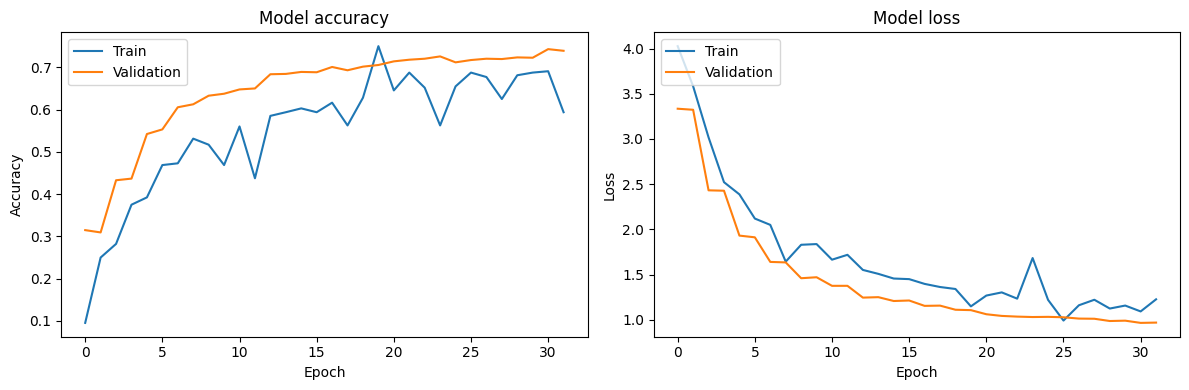

In [ ]:

if vgg_history is not None:
    plt.figure(figsize=(12, 4))  # Set the figure size for the plots

    # Plot accuracy
    plt.subplot(1, 2, 1)  # Create the first subplot (1 row, 2 columns, 1st plot)
    plt.plot(history.history['accuracy'])  # Plot training accuracy over epochs
    plt.plot(history.history['val_accuracy'])  # Plot validation accuracy over epochs
    plt.title('Model accuracy')  # Set the title for the accuracy plot
    plt.ylabel('Accuracy')  # Label for the y-axis
    plt.xlabel('Epoch')  # Label for the x-axis
    plt.legend(['Train', 'Validation'], loc='upper left')  # Add legend

    # Plot loss
    plt.subplot(1, 2, 2)  # Create the second subplot (1 row, 2 columns, 2nd plot)
    plt.plot(history.history['loss'])  # Plot training loss over epochs
    plt.plot(history.history['val_loss'])  # Plot validation loss over epochs
    plt.title('Model loss')  # Set the title for the loss plot
    plt.ylabel('Loss')  # Label for the y-axis
    plt.xlabel('Epoch')  # Label for the x-axis
    plt.legend(['Train', 'Validation'], loc='upper left')  # Add legend

    plt.tight_layout()  # Adjust the layout to prevent overlapping
    plt.show()  # Display the plots
else:
    print("No training history available to plot.")

## 3.3.1 Analysis 

### 📈 Left Plot – *Model Accuracy*:

* **Training Accuracy** steadily improves but fluctuates quite a bit, especially after epoch 10.
* **Validation Accuracy** consistently improves and levels off, peaking near 0.75 by the end.
* 🔎 **Interpretation**:

  * Validation accuracy > training accuracy throughout — this is unusual.
  * Could indicate **regularization (like dropout)** being applied only during training, or **small/noisy training data**.

---

### 📉 Right Plot – *Model Loss*:

* **Training Loss** decreases but is erratic after epoch 10.
* **Validation Loss** steadily and smoothly decreases.
* 🔎 **Interpretation**:

  * Model generalizes well (validation loss improves).
  * Training loss not converging smoothly might suggest:

    * Small dataset
    * High learning rate
    * Dropout or other regularization affecting training performance

---

### ✅ Overall Summary:

* Model **is not overfitting** (validation metrics improve steadily).
* **Training instability** hints at:

  * Need to smooth learning rate
  * Augment (resize) and/or expand training data
  * Review regularization strategy



In [ ]:
# Data generator for test images (no augmentation, only normalization)
test_datagen_224 = ImageDataGenerator(rescale=1./255)

# Generate batches of test data
test_generator_224 = test_datagen_224.flow_from_dataframe(
    dataframe=test_df,            # Test dataset
    directory=image_dir,          # Path to images
    x_col='filename',             # Column with image file names
    y_col='label',                # Column with corresponding labels
    target_size=(224, 224),       # Resize images to 224x224
    batch_size=32,                # Number of images per batch
    class_mode='categorical'      # Labels are categorical
)

# Data generator for validation images (no augmentation, only normalization)
val_datagen_224 = ImageDataGenerator(rescale=1./255)

# Generate batches of validation data
val_generator_224 = val_datagen_224.flow_from_dataframe(
    dataframe=val_df,             # Validation dataset
    directory=image_dir,          # Path to images
    x_col='filename',             # Column with image file names
    y_col='label',                # Column with corresponding labels
    target_size=(224, 224),       # Resize images to 224x224
    batch_size=32,                # Number of images per batch
    class_mode='categorical'      # Labels are categorical
)

train_datagen_224 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator_224 = train_datagen_224.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),   # ✅ This must match VGG16's expected input
    batch_size=32,
    class_mode='categorical'
)

# === Load Base VGG16 and Freeze Layers ===
base_model = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze now, unfreeze later if fine-tuning

# === Build Custom Classifier on Top ===
model_vgg_opt = Sequential([
    base_model,
    GlobalAveragePooling2D(),

    BatchNormalization(),  # Helps with training stability

    Dense(512, activation='relu'),
    BatchNormalization(),

    Dropout(0.3),  # Helps prevent overfitting with reduced dropout

    Dense(num_classes, activation='softmax')
])

# === Compile with Optimizer ===
optimizer = Adam(learning_rate=1e-4)  # Lower LR for better convergence
model_vgg_opt.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === Setup Training Callbacks ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    ModelCheckpoint('best_model_opt_vgg.keras', save_best_only=True, monitor='val_loss')
]

# === Load Saved Model if Available ===
opt_model_path = "./model_VGG_opt.keras"  # Fixed path for cross-platform compatibility

if os.path.exists(opt_model_path):
    model_vgg_opt = load_model(opt_model_path)
    print("VGG Optimized Model loaded.")
else:
    # === Train the Model ===
    model_vgg_opt_history = model_vgg_opt.fit(
        train_generator_224,
        steps_per_epoch=train_generator_224.samples // train_generator_224.batch_size,
        epochs=40,
        validation_data=val_generator_224,
        validation_steps=val_generator_224.samples // val_generator_224.batch_size,
        callbacks=callbacks
    )

    # Save the model for future reuse
    model_vgg_opt.save(opt_model_path)


Found 650 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.
Found 4549 validated image filenames belonging to 75 classes.
Epoch 1/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 430s 3s/step - accuracy: 0.0452 - loss: 4.9001 - val_accuracy: 0.0641 - val_loss: 4.0742 - learning_rate: 1.0000e-04
Epoch 2/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 91s 629ms/step - accuracy: 0.0938 - loss: 4.0368 - val_accuracy: 0.0641 - val_loss: 4.0726 - learning_rate: 1.0000e-04
Epoch 3/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 414s 3s/step - accuracy: 0.2276 - loss: 3.2332 - val_accuracy: 0.2852 - val_loss: 3.2800 - learning_rate: 1.0000e-04
Epoch 4/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 92s 633ms/step - accuracy: 0.5312 - loss: 2.4240 - val_accuracy: 0.2898 - val_loss: 3.2722 - learning_rate: 1.0000e-04
Epoch 5/40
142/142 ━━━━━━━━━━━━━━━━━━━━ 414s 3s/step - accuracy: 0.4128 - loss: 2.3665 - val_accuracy: 0.4953 - val_loss: 2.3249 - learning_rate: 1.0000e-04
Epoch 6/40
142/142 ━━━━━━━

## 3.4 Compare models

To assess the effectiveness of three image classification models—**FNN**, **CNN**, and a **VGG-based transfer learning model** -  I compared their accuracy to highlight key strengths and limitations:

* **🧠 FNN (Fully Connected Neural Network):**

  * Serves as a baseline using flattened image data.
  * Accuracy was moderate, limited by its inability to capture spatial patterns.
  * Best suited for non-visual data or simple image tasks.

* **🧩 CNN (Convolutional Neural Network):**

  * Designed for image data, leveraging convolutional layers to extract spatial features.
  * Delivered stronger results than FNN, showing clear advantages in visual pattern recognition.
  * Demonstrates the importance of architecture tailored to image data.

* **🚀 VGG (Transfer Learning):**

  * Uses pre-trained VGG16 layers to extract high-level features.
  * Achieved the highest accuracy, especially effective on limited data.
  * Highlights the power of transfer learning to boost performance with minimal training.
  * Two versions of this, one more optimized...and longest training.



In [41]:
def get_evaluation_metrics(model, test_generator):
    # Evaluate the model on test data
    test_loss, test_acc = model.evaluate(
        test_generator, 
        steps=test_generator.samples // test_generator.batch_size,
        verbose=0
    )

    # Predict (optional: include if you want to get confusion matrix, F1, etc.)
    y_pred = model.predict(
        test_generator, 
        steps=test_generator.samples // test_generator.batch_size,
        verbose=0
    )

    return test_loss, test_acc

In [56]:
# Data generator for test images (no augmentation, only normalization)
test_datagen_224 = ImageDataGenerator(rescale=1./255)

# Generate batches of test data
test_generator_224 = test_datagen_224.flow_from_dataframe(
    dataframe=test_df,            # Test dataset
    directory=image_dir,          # Path to images
    x_col='filename',             # Column with image file names
    y_col='label',                # Column with corresponding labels
    target_size=(224, 224),       # Resize images to 224x224
    batch_size=32,                # Number of images per batch
    class_mode='categorical'      # Labels are categorical
)

# Data generator for validation images (no augmentation, only normalization)
val_datagen_224 = ImageDataGenerator(rescale=1./255)

# Generate batches of validation data
val_generator_224 = val_datagen_224.flow_from_dataframe(
    dataframe=val_df,             # Validation dataset
    directory=image_dir,          # Path to images
    x_col='filename',             # Column with image file names
    y_col='label',                # Column with corresponding labels
    target_size=(224, 224),       # Resize images to 224x224
    batch_size=32,                # Number of images per batch
    class_mode='categorical'      # Labels are categorical
)

train_datagen_224 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator_224 = train_datagen_224.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),   # ✅ This must match VGG16's expected input
    batch_size=32,
    class_mode='categorical'
)


# Get metrics for each model
fnn_loss, fnn_acc = get_evaluation_metrics(model_FNN, test_generator)
cnn_loss, cnn_acc = get_evaluation_metrics(model_CNN, test_generator)
vgg_loss, vgg_acc = get_evaluation_metrics(model_vgg, test_generator)
vgg__opt_loss, vgg__opt_acc = get_evaluation_metrics(model_vgg_opt, test_generator_224)

# Prepare for plotting
models = ['FNN', 'CNN', 'vgg', 'vgg_opt']
accuracy = [fnn_acc, cnn_acc, vgg_acc, vgg__opt_acc]
loss = [fnn_loss, cnn_loss, vgg_loss, vgg__opt_loss]


Found 650 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.
Found 4549 validated image filenames belonging to 75 classes.


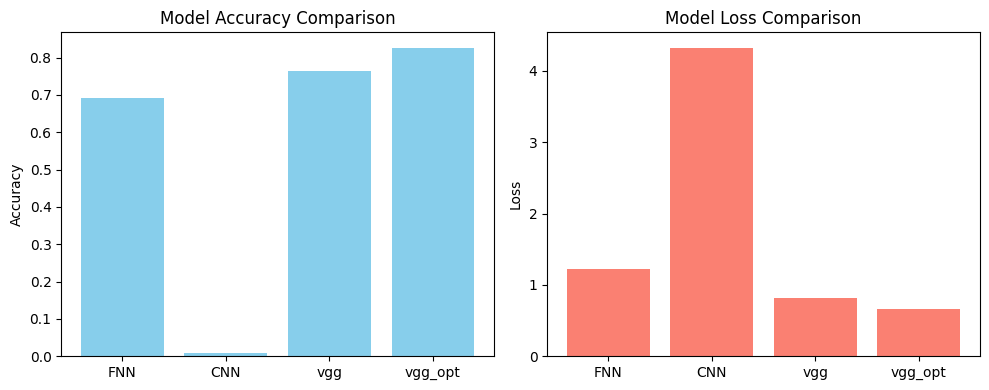

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.bar(models, accuracy, color='skyblue')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.bar(models, loss, color='salmon')
plt.title('Model Loss Comparison')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


In [ ]:
# get_evaluation_metrics(model_vgg, train_generator)

142/142 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.8102 - loss: 0.7289
142/142 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step


## Final insight/conclusion

### 📊 **Model Accuracy (Left Chart)**

| Model             | Accuracy (Est.) | Notes                                                               |
| ----------------- | --------------- | ------------------------------------------------------------------- |
| **FNN**           | \~0.69          | Decent, but not optimal. Likely limited by architecture simplicity. |
| **CNN**           | \~0.01          | **Very poor**. Severe underfitting or data/input shape mismatch.    |
| **VGG**           | \~0.76          | Strong performance. Transfer learning helps.                        |
| **VGG Optimized** | \~0.83          | Best accuracy — batch norm, dropout tuning, and callbacks helped.   |

---

### 📉 **Model Loss (Right Chart)**

| Model             | Loss (Est.) | Notes                                             |
| ----------------- | ----------- | ------------------------------------------------- |
| **FNN**           | \~1.25      | Acceptable but higher than ideal.                 |
| **CNN**           | \~4.3       | **Very bad** — confirms model failed to learn.    |
| **VGG**           | \~0.8       | Lower loss = better generalization.               |
| **VGG Optimized** | \~0.65      | Best loss = well-regularized and converged model. |

---

### 🧠 Interpretation

* **CNN failed dramatically** — likely due to:

  * Wrong input shape
  * Bad architecture or too shallow
  * Miscompiled model or wrong data mapping

* **VGG models shine** thanks to:

  * Pretrained weights (transfer learning)
  * Proper input size (224x224)
  * Fine-tuning (`vgg_opt`) gives best results

* **FNN is passable**, but:

  * Likely doesn't capture spatial features of image data as well as CNNs
  * Okay for baselines but not ideal for computer vision tasks

---

### ✅ Recommendation

* Stick with `vgg_opt` for deployment or further testing.
* Investigate the CNN model:

  * Print model summary
  * Verify image input shape
  * Check training history — did loss ever go down?
* Consider unfreezing top layers of VGG for **fine-tuning phase** if needed.

